# Predicting House Prices with Logistic Regression 📈

**Authors:** [Melissa Perez](https://github.com/MelissaPerez09), [Adrian Flores](https://github.com/adrianRFlores), [Andrea Ramirez](https://github.com/Andrea-gt)

**Description:**

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score,
precision_score, recall_score, ConfusionMatrixDisplay, classification_report, roc_curve, auc)
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr

random_state = 42
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = figsize=(6,4)

## Data Upload 📄

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Feature Engineering 🗂️

### Handling Missing Values

In [3]:
# Fill missing values in low NaN count columns
df['Electrical'] = df['Electrical'].fillna('None')
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [4]:
# Impute missing LotFrontage values based on the median LotFrontage within each neighborhood.
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [5]:
# Fill missing values in FireplaceQu with 'None'.
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

In [6]:
# Fill missing values in garage-related variables with 'None'.
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')

In [7]:
# Fill missing values in basement-related variables with 'None'.
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

In [8]:
# Drop columns with a high count of missing values
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [9]:
# Make a copy of the dataframe
df_scp = df.copy()

### Feature Creation

In [10]:
# Define conditions for categorizing SalePrice
conditions = [
    (df['SalePrice'] < 150000),
    (df['SalePrice'] >= 150000) & (df['SalePrice'] <= 250000),
    (df['SalePrice'] > 250000)
]

# Define labels for the categories
labels = ['economical', 'intermediate', 'expensive']

# Create a new column 'SalePriceCategory' based on the conditions and labels
df['SalePriceCategory'] = np.select(conditions, labels)

df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceCategory
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500,intermediate
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500,intermediate
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500,intermediate
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,140000,economical
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000,intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,8,2007,WD,Normal,175000,intermediate
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2010,WD,Normal,210000,intermediate
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,2500,5,2010,WD,Normal,266500,expensive
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,4,2010,WD,Normal,142125,economical


### Feature Encoding

In [11]:
# Columns to encode, separated by feature category
nominalFeatures = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                    'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType',
                    'SaleCondition','PavedDrive', 'SalePriceCategory']

ordinalFeatures = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageQual', 'GarageCond']

otherOrdinalFeatures = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish']

In [12]:
# Convert nominal features into dummy variables
# Get dummies for nominal features
dummies = pd.get_dummies(df[nominalFeatures])
dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,False,False,False,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
1,False,False,False,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
2,False,False,False,True,False,False,True,True,False,False,...,False,False,True,False,False,False,True,False,False,True
3,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,True,True,False,False
4,False,False,False,True,False,False,True,True,False,False,...,False,False,True,False,False,False,True,False,False,True


In [13]:
# Drop the original nominal features columns
df = df.drop(nominalFeatures, axis=1)

# Concatenate dummies with original DataFrame
df = pd.concat([df, dummies], axis=1)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,1,60,65.0,8450,7,5,2003,2003,196.0,Gd,...,False,False,True,False,False,False,True,False,False,True
1,2,20,80.0,9600,6,8,1976,1976,0.0,TA,...,False,False,True,False,False,False,True,False,False,True
2,3,60,68.0,11250,7,5,2001,2002,162.0,Gd,...,False,False,True,False,False,False,True,False,False,True
3,4,70,60.0,9550,7,5,1915,1970,0.0,TA,...,False,False,False,False,False,False,True,True,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,Gd,...,False,False,True,False,False,False,True,False,False,True


In [14]:
# Initialize the OrdinalEncoder
encoder = OrdinalEncoder()

# Define ordinal categories
ordinalCategories = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

# Reshape the ordinal categories array
ordinalCategories = np.array(ordinalCategories).reshape(-1, 1)

# Fit the encoder to the ordinal categories
encoder.fit(ordinalCategories)

# Encode columns to in ordinalFeatures
for feature in ordinalFeatures:
    df[[feature]] = encoder.transform(df[[feature]])

df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,1,60,65.0,8450,7,5,2003,2003,196.0,2.0,...,False,False,True,False,False,False,True,False,False,True
1,2,20,80.0,9600,6,8,1976,1976,0.0,5.0,...,False,False,True,False,False,False,True,False,False,True
2,3,60,68.0,11250,7,5,2001,2002,162.0,2.0,...,False,False,True,False,False,False,True,False,False,True
3,4,70,60.0,9550,7,5,1915,1970,0.0,5.0,...,False,False,False,False,False,False,True,True,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,2.0,...,False,False,True,False,False,False,True,False,False,True


In [15]:
# Define encoding categories for each other ordinal feature
encodingCategories = [
    ['None', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['None', 'Unf', 'RFn', 'Fin']  # GarageFinish
]

# Reshape the ordinal categories array
reshapedEncodingCategories = [np.array(categories).reshape(-1, 1) for categories in encodingCategories]

# Encode columns in otherOrdinalFeatures
for feature, categories in zip(otherOrdinalFeatures, reshapedEncodingCategories):
    # Fit the encoder to the encoding categories
    encoder.fit(categories)
    df[[feature]] = encoder.transform(df[[feature]])

df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,1,60,65.0,8450,7,5,2003,2003,196.0,2.0,...,False,False,True,False,False,False,True,False,False,True
1,2,20,80.0,9600,6,8,1976,1976,0.0,5.0,...,False,False,True,False,False,False,True,False,False,True
2,3,60,68.0,11250,7,5,2001,2002,162.0,2.0,...,False,False,True,False,False,False,True,False,False,True
3,4,70,60.0,9550,7,5,1915,1970,0.0,5.0,...,False,False,False,False,False,False,True,True,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,2.0,...,False,False,True,False,False,False,True,False,False,True


## Log. Regression Models

### Initial Iteration - Identifying House Pricings (Using All Variables)

#### Splitting DataSets for First Iteration

In [16]:
# Make another copy of the dataframe
df_cp = df.copy()

# Expensive DataSet Splitting
# Separate the target variable 'SalePriceCategory' from features
y_expensive = df_cp.pop('SalePriceCategory_expensive')

# Exclude columns 'Id' and SalePriceCategory(s) from features
X_expensive = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice', 'SalePriceCategory_economical', 'SalePriceCategory_intermediate'])]

In [17]:
# Intermediate DataSet Splitting
# Make another copy of the dataframe
df_cp = df.copy()

# Separate the target variable 'SalePriceCategory' from features
y_intermediate = df_cp.pop('SalePriceCategory_intermediate')

# Exclude columns 'Id' and SalePriceCategory(s) from features
X_intermediate = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice', 'SalePriceCategory_economical', 'SalePriceCategory_expensive'])]

In [18]:
# Economical DataSet Splitting
# Make another copy of the dataframe
df_cp = df.copy()

# Separate the target variable 'SalePriceCategory' from features
y_economical = df_cp.pop('SalePriceCategory_economical')

# Exclude columns 'Id' and SalePriceCategory(s) from features
X_economical = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice', 'SalePriceCategory_intermediate', 'SalePriceCategory_expensive'])]

In [19]:
# Expensive DataSet Splitting
# Split the data into training and testing sets
X_train_expensive, X_test_expensive, y_train_expensive, y_test_expensive = train_test_split(X_expensive, y_expensive, test_size=0.2, train_size=0.8, random_state=random_state)

In [20]:
# Intermediate DataSet Splitting
# Split the data into training and testing sets
X_train_intermediate, X_test_intermediate, y_train_intermediate, y_test_intermediate = train_test_split(X_intermediate, y_intermediate,
                                                                                                        test_size=0.2, train_size=0.8, random_state=random_state)

In [21]:
# Economical DataSet Splitting
# Split the data into training and testing sets
X_train_economical, X_test_economical, y_train_economical, y_test_economical = train_test_split(X_economical, y_economical,
                                                                                                test_size=0.2, train_size=0.8, random_state=random_state)

In [22]:
print(X_train_expensive.shape)
print(X_test_expensive.shape)

(1168, 224)
(292, 224)


In [23]:
print(X_train_intermediate.shape)
print(X_test_intermediate.shape)

(1168, 224)
(292, 224)


In [24]:
print(X_train_intermediate.shape)
print(X_test_intermediate.shape)

(1168, 224)
(292, 224)


#### First Iteration - Logistic Regression Models (All Features)

##### Logistic Regression Models

**Expensive Houses Logistic Regression Model**

In [25]:
# Initialize Logistic Regression model with cross-validation
clf_ex = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

# Fit the expensive model to the training data
clf_expensive = clf_ex.fit(X_train_expensive, y_train_expensive)

# Predict the target variable using the model on the train data
y_test_pred_expensive = clf_ex.predict(X_test_expensive)

# Predict the target variable using the trained model on the train data
y_train_pred_expensive = clf_expensive.predict(X_train_expensive)

**Intermediate Houses Logistic Regression Model**

In [26]:
# Initialize Logistic Regression model with cross-validation
clf_in = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

# Fit the intermediate model to the training data
clf_intermediate = clf_in.fit(X_train_intermediate, y_train_intermediate)

# Predict the target variable using the model on the test data
y_test_pred_intermediate = clf_in.predict(X_test_intermediate)

# Predict the target variable using the model on the train data
y_train_pred_intermediate = clf_intermediate.predict(X_train_intermediate)

**Economical Houses Logistic Regression Model**

In [27]:
# Initialize Logistic Regression model with cross-validation
clf_ec = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

# Fit the economical model to the training data
clf_economical = clf_ec.fit(X_train_economical, y_train_economical)

# Predict the target variable using the model on the test data
y_test_pred_economical = clf_economical.predict(X_test_economical)

# Predict the target variable using the model on the train data
y_train_pred_economical = clf_economical.predict(X_train_economical)

##### Results, Findings and Insights

In [28]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, y_test_pred_expensive)))
print("Intermediate Houses Classifier: {:.2f}".format(accuracy_score(y_test_intermediate, y_test_pred_intermediate)))
print("Economical Houses Classifier: {:.2f}".format(accuracy_score(y_test_economical, y_test_pred_economical)))
print()

# Accuracy scores for train set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, y_train_pred_expensive)))
print("Intermediate Houses Classifier: {:.2f}".format(accuracy_score(y_train_intermediate, y_train_pred_intermediate)))
print("Economical Houses Classifier: {:.2f}".format(accuracy_score(y_train_economical, y_train_pred_economical)))

Accuracy Scores on Test Set:
---------------------------------------
Expensive Houses Classifier: 0.95
Intermediate Houses Classifier: 0.80
Economical Houses Classifier: 0.92

Accuracy Scores on Train Set:
---------------------------------------
Expensive Houses Classifier: 0.97
Intermediate Houses Classifier: 0.83
Economical Houses Classifier: 0.95


A través de un detallado análisis de los resultados obtenidos mediante la aplicación de los diversos modelos de clasificación de casas en los conjuntos de prueba y de testeo, se muestras importantes insights acerca de su rendimiento y capacidad de generalización de datos.

1. Clasificador de Casas de Gama Alta:

    - Se evidencia una precisión de 0.95 para el conjunto de datos de testeo.
    - Se evidencia una precisión de 0.97 para el conjunto de datos de prueba.

      El modelo de regresión logística aplicado a la clasificación de casas de gama alta exhibe un nivel de precisión notable tanto en el conjunto de datos de prueba como en el de entrenamiento. Esto sugiere que el modelo desarrollado posee la capacidad de generalizar adecuadamente datos no observados previamente. Es importante destacar que se observa una ligera disminución en la precisión del modelo al aplicarlo al conjunto de datos de prueba en comparación con el de entrenamiento, lo cual podría indicar un mínima sobreajuste en el modelo. Esta discrepancia puede surgir debido a la presencia de ruido en el conjunto de datos de entrenamiento. En este contexto, resulta escencial considerar la implementación de técnicas de regularización, las cuales serán abordadas más adelante en este documento.

      No obstante, en líneas generales, el modelo muestra un desempeño sobresaliente y métricas bastante alentadoras. El elevado nivel de precisión obtenido sugiere que las características empleadas en la construcción del modelo son capaces de identificar y distinguir de manera precisa las casas de gama alta del resto.

2. Clasificador de Casas de Gama Media:

    - Se evidencia una precisión de 0.80 para el conjunto de datos de testeo.
    - Se evidencia una precisión de 0.83 para el conjunto de datos de prueba.

      El modelo de regresión logística aplicado a la clasificación de casas de gama media también exhibe un nivel de precisión considerablemente bueno en ambos conjuntos de datos. Sin embargo, es en este modelo en donde se evidencia una disminución notable en la precisión cuando el modelo es aplicado en el conjunto de datos de testeo. Nuevamente, esto sugiere la existencia de un sobreajuste, posiblemente más grande que el del modelo descrito con anterioridad. Aunque no es alarmante, y el modelo brinda resultados aceptables, es posible inferir que está teniendo problemas al generalizar la data que aún no ha visto. Puede que esita una ventana de mejora en la selección de características.  

3. Clasificador de Casas Económicas:

    - Se evidencia una precisión de 0.92 para el conjunto de datos de testeo.
    - Se evidencia una precisión de 0.95 para el conjunto de datos de prueba.
  
      El modelo de regresión logística aplicado a la clasificación de casas económicas exhibe un nivel de precisión excelente en ambos conjuntos de datos. Aunque también se percibe cierto nivel de sobreajuste, este es mínimo.

**Logistic Regression Model to Identify Expensive Houses - Results**

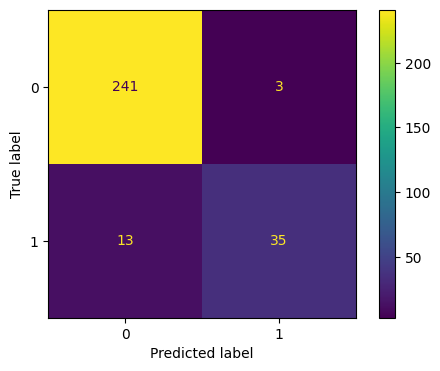

In [29]:
# Logistic Regression Model to Identify Expensive Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, y_test_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de prueba:
- Para la clase 0 (casas económicas e intermedias), se clasificaron correctamente 241 casos.
- Para la clase 1 (casas de gama alta), se clasificaron correctamente 35 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas de gama alta (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media y baja (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

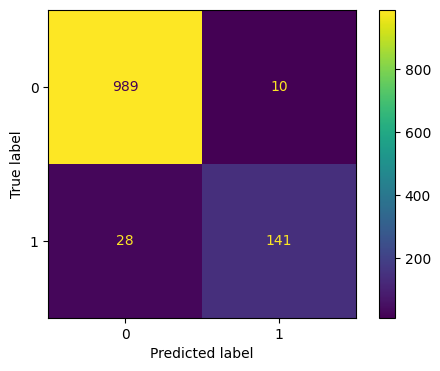

In [30]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, y_train_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de entrenamiento:
- Para la clase 0 (casas económicas y de gama media), se clasificaron correctamente 989 casos.
- Para la clase 1 (casas de gama alta), se clasificaron correctamente 141 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas de gama alta (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas económicas y de gama media (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

Los errores de clasificación, en el contexto de la predicción de casas de gama alta, pueden tener implicaciones financieras. Identificar y corregir las fuentes de error en la predicción de casas de gama alta puede ser crucial para mejorar la rentabilidad y la satisfacción del cliente en el mercado inmobiliario.

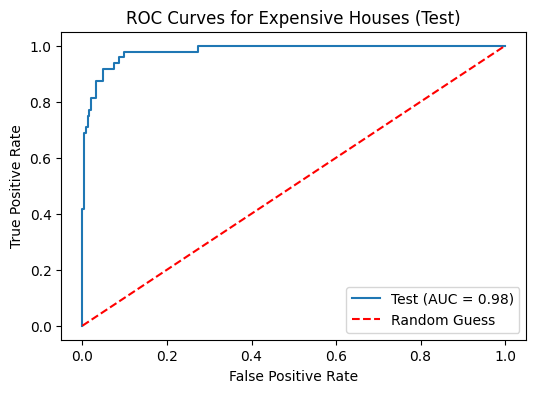

In [31]:
y_pred1 = clf_ex.predict_proba(X_test_expensive)[:,1]
#y_pred2 = clf_ex.predict_proba(X_train_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_expensive, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Test)')
plt.legend()
plt.show()

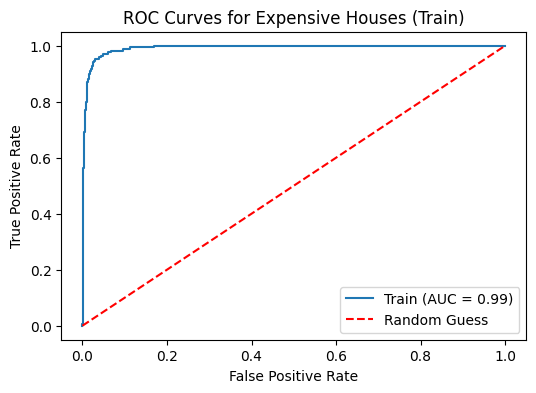

In [32]:
y_pred1 = clf_ex.predict_proba(X_train_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_expensive, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Train)')
plt.legend()
plt.show()

Un AUC (Área bajo la curva ROC) de 0.98 en el conjunto de datos de prueba y de 0.99 en el conjunto de datos de entrenamiento indica que el modelo de regresión logística está teniendo un excelente desempeño en la clasificación binaria.

**Logistic Regression Model to Identify Intermediate Houses - Results**

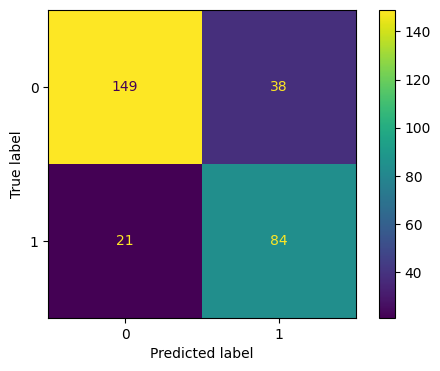

In [33]:
# Logistic Regression Model to Identify Intermediate Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_intermediate, y_test_pred_intermediate)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de prueba:
- Para la clase 0 (casas económicas y de gama alta), se clasificaron correctamente 149 casos.
- Para la clase 1 (casas de gama media), se clasificaron correctamente 84 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas económicas y de gama alta (clase 0), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media (clase 1), ya que tiene el menor número de clasificaciones erróneas totales.

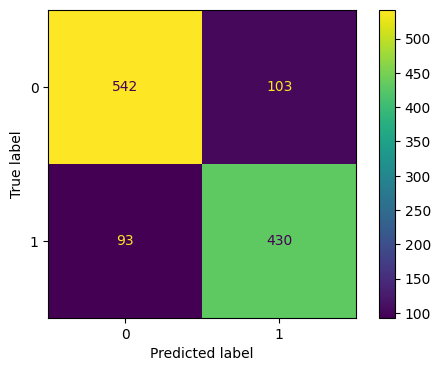

In [34]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_intermediate, y_train_pred_intermediate)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de entrenamiento:
- Para la clase 0 (casas económicas y de gama alta), se clasificaron correctamente 542 casos.
- Para la clase 1 (casas de gama media), se clasificaron correctamente 430 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas económicas y de gama alta (clase 0), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media (clase 1), ya que tiene el menor número de clasificaciones erróneas totales.

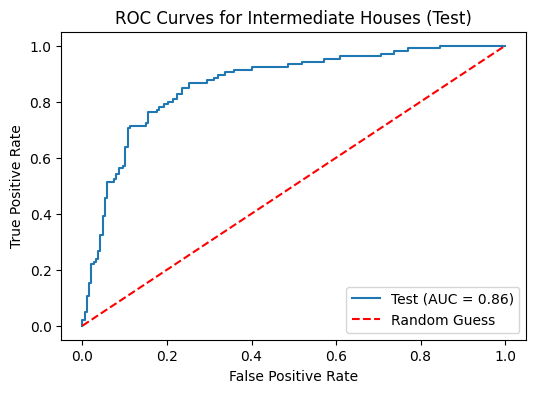

In [35]:
y_pred1 = clf_in.predict_proba(X_test_intermediate)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_intermediate, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Intermediate Houses (Test)')
plt.legend()
plt.show()

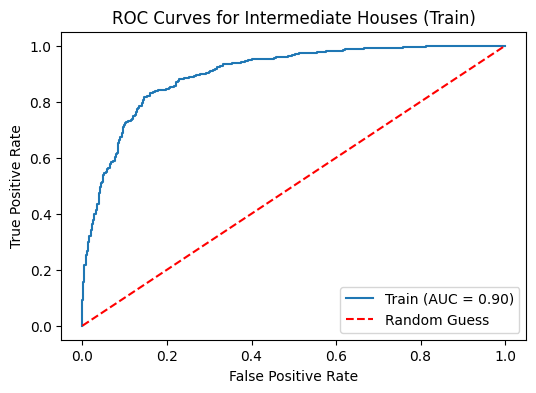

In [36]:
y_pred1 = clf_in.predict_proba(X_train_intermediate)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_intermediate, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Intermediate Houses (Train)')
plt.legend()
plt.show()

El modelo de regresión logística para clasificar casas de gama media muestra un buen rendimiento con un AUC de 0.86 en el conjunto de datos de prueba y 0.90 en el conjunto de entrenamiento, aunque la discrepancia entre ambos sugiere posible sobreajuste.

**Logistic Regression Model to Identify Economical Houses - Results**

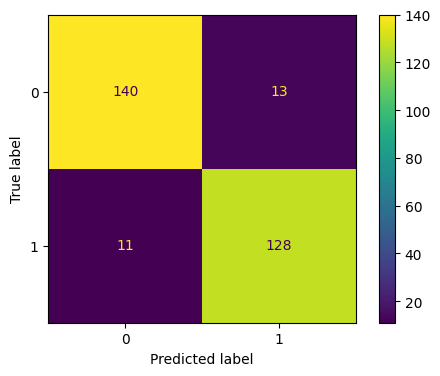

In [37]:
# Logistic Regression Model to Identify Economical Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_economical, y_test_pred_economical)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de prueba:
- Para la clase 0 (casas de gama media y alta), se clasificaron correctamente 140 casos.
- Para la clase 1 (casas económicas), se clasificaron correctamente 128 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas de gama media y alta (clase 0), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas económicas (clase 1), ya que tiene el menor número de clasificaciones erróneas totales.

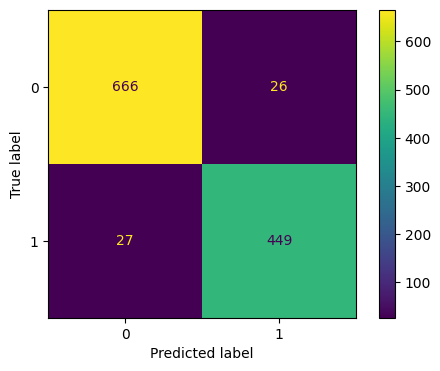

In [38]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_economical, y_train_pred_economical)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de entrenamiento:
- Para la clase 0 (casas de gama media y alta), se clasificaron correctamente 666 casos.
- Para la clase 1 (casas económicas), se clasificaron correctamente 449 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas económicas (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media y alta (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

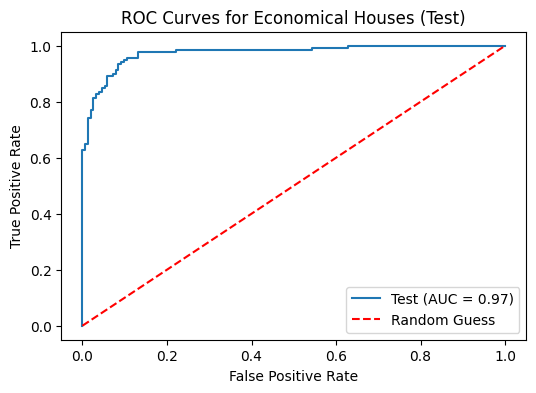

In [39]:
y_pred1 = clf_ec.predict_proba(X_test_economical)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_economical, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Economical Houses (Test)')
plt.legend()
plt.show()

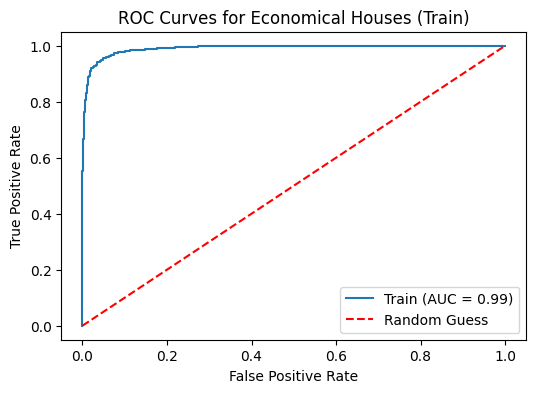

In [40]:
y_pred1 = clf_ec.predict_proba(X_train_economical)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_economical, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Economical Houses (Train)')
plt.legend()
plt.show()

El modelo de regresión logística para clasificar casas de gama económica exhibe un rendimiento sólido, como lo indica un AUC de 0.97 en el conjunto de datos de prueba y de 0.99 en el conjunto de entrenamiento. La ligera discrepancia entre ambos conjuntos podría sugerir una posible sobreajuste, pero dado que ambos valores son altos, el modelo aún demuestra una capacidad robusta de generalización.

En el contexto de la predicción del precio de las viviendas, los errores de clasificación son fuertemente significativos, dada su capacidad para generar consecuencias adversas. Estos errores podrían desencadenar decisiones financieras erróneas, lo que potencialmente conduciría a péridas. Además, podrían impactar de manera negativa la experiencia y satisfacción de clientes del mercado inmobiliario. Por consiguiente, la identificación y corrección de las fuentes de error en la predicción de los precios de las casas es crucial.

### Second Iteration - Identifying House Pricings (With Feature Engineering)

##### Choosing Best Predictors Based on a Correlation Analysis

In [41]:
# Select only the boolean columns
bool_df = df.select_dtypes(include=bool)

# Convert boolean columns to integer
intBool = bool_df.astype(int)

# Concatenate the integer boolean columns with the non-boolean columns
test = pd.concat([intBool, df.drop(columns=bool_df.columns)], axis=1)
test

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0,0,0,1,0,0,1,0,0,0,...,0,61,0,0,0,0,0,2,2008,208500
1,0,0,0,1,0,0,1,0,0,0,...,298,0,0,0,0,0,0,5,2007,181500
2,0,0,0,1,0,0,1,1,0,0,...,0,42,0,0,0,0,0,9,2008,223500
3,0,0,0,1,0,0,1,1,0,0,...,0,35,272,0,0,0,0,2,2006,140000
4,0,0,0,1,0,0,1,1,0,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,1,0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,0,0,0,1,0,0,1,0,0,0,...,349,0,0,0,0,0,0,2,2010,210000
1457,0,0,0,1,0,0,1,0,0,0,...,0,60,0,0,0,0,2500,5,2010,266500
1458,0,0,0,1,0,0,1,0,0,0,...,366,0,112,0,0,0,0,4,2010,142125


In [42]:
selectedColumns = []
salePriceData = df['SalePrice']

df_numerical_cp = test.select_dtypes(include=[np.number])

# Concatenate the integer boolean columns with the non-boolean columns
test = pd.concat([intBool, df.drop(columns=bool_df.columns)], axis=1)

for col in df_numerical_cp.columns:
    colData = df_numerical_cp[col]
    corr, p_value = spearmanr(salePriceData, colData)
    if abs(corr) >= 0.50:
      if col != 'SalePrice' and col != 'SalePriceCategory_economical' and col != 'SalePriceCategory_expensive' :
        print(f"Column '{col}' spearman correlation coefficient:", corr)
        selectedColumns.append(col)

Column 'Foundation_PConc' spearman correlation coefficient: 0.5622872399508613
Column 'OverallQual' spearman correlation coefficient: 0.8098285862017292
Column 'YearBuilt' spearman correlation coefficient: 0.6526815462850586
Column 'YearRemodAdd' spearman correlation coefficient: 0.5711589780582342
Column 'ExterQual' spearman correlation coefficient: -0.6333152853927962
Column 'BsmtQual' spearman correlation coefficient: -0.5714411084616451
Column 'TotalBsmtSF' spearman correlation coefficient: 0.6027254448924096
Column '1stFlrSF' spearman correlation coefficient: 0.5754078354212824
Column 'GrLivArea' spearman correlation coefficient: 0.7313095834659141
Column 'FullBath' spearman correlation coefficient: 0.6359570562496957
Column 'KitchenQual' spearman correlation coefficient: -0.569856550713747
Column 'TotRmsAbvGrd' spearman correlation coefficient: 0.5325859351169929
Column 'Fireplaces' spearman correlation coefficient: 0.5192474498367013
Column 'GarageYrBlt' spearman correlation coe

In [105]:
test = X_test_expensive[selectedColumns]

Analisis aquiiii

##### Multicollinearity Analysis Using Variance Inflation Factor (VIF) and HeatMaps

In [106]:
# Select only the boolean columns
bool_df = test.select_dtypes(include=bool)

# Convert boolean columns to integer
intBool = bool_df.astype(int)

# Concatenate the integer boolean columns with the non-boolean columns
test = pd.concat([intBool, test.drop(columns=bool_df.columns)], axis=1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i) for i in range(len(test.columns))]

In [107]:
vif_data

,feature,VIF
0,Foundation_PConc,4.803587
1,OverallQual,71.524186
2,YearBuilt,10559.426813
3,YearRemodAdd,10580.190605
4,ExterQual,20.039303
5,BsmtQual,10.880888
6,TotalBsmtSF,22.593108
7,1stFlrSF,35.065165
8,GrLivArea,49.587852
9,FullBath,19.623884


In [108]:
# Binary feature indicating whether the house was remodeled or not.
test['Remodeled'] = (test['YearRemodAdd'] != test['YearBuilt']).astype(int)

# List of columns to drop
columnstoDrop = ['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd', 'KitchenQual', 'BsmtQual', 'ExterQual', '1stFlrSF',
                 'TotalBsmtSF', 'GarageArea', 'FullBath', 'Fireplaces', 'OverallQual', 'YearRemodAdd', 'YearBuilt']

# Drop the specified columns
test = test.drop(columns=columnstoDrop)

test

,Foundation_PConc,GrLivArea,Remodeled
892,0,1068,1
1105,1,2622,1
413,0,1028,1
522,0,1664,1
1036,1,1620,1
...,...,...,...
479,0,1131,1
1361,1,1530,0
802,1,1456,0
651,0,1510,1


In [109]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i) for i in range(len(test.columns))]

In [110]:
vif_data

,feature,VIF
0,Foundation_PConc,2.124837
1,GrLivArea,3.213817
2,Remodeled,1.798941


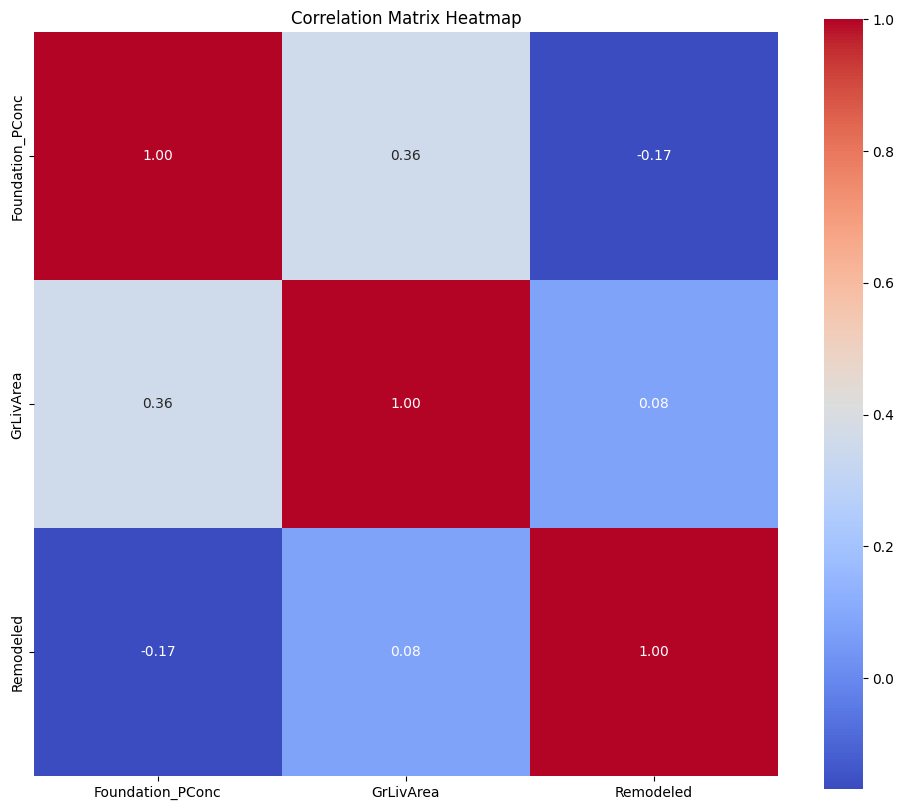

In [111]:
corrMatrix = test.corr()
tidy_corr_matrix = corrMatrix.reset_index().melt(id_vars='index').rename(columns={'index': 'Variable 1', 'variable': 'Variable 2', 'value': 'Correlation'})
tidy_corr_matrix = tidy_corr_matrix[tidy_corr_matrix['Variable 1'] != tidy_corr_matrix['Variable 2']]

plt.figure(figsize=(12, 10))
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [119]:
# Exclude columns 'Id' and SalePriceCategory(s) from features
X_expensive_cp = X_expensive

# Binary feature indicating whether the house was remodeled or not.
X_expensive_cp['Remodeled'] = (X_expensive_cp['YearRemodAdd'] != X_expensive_cp['YearBuilt']).astype(int)
X_expensive_cp = X_expensive_cp[['Foundation_PConc', 'GrLivArea', 'Remodeled']]
X_expensive_cp

,Foundation_PConc,GrLivArea,Remodeled
0,True,1710,0
1,False,1262,0
2,True,1786,1
3,False,1717,1
4,True,2198,0
...,...,...,...
1455,True,1647,1
1456,False,2073,1
1457,False,2340,1
1458,False,1078,1


In [120]:
# Expensive DataSet Splitting
# Split the data into training and testing sets
X_train_expensive, X_test_expensive, y_train_expensive, y_test_expensive = train_test_split(X_expensive_cp, y_expensive, test_size=0.2, train_size=0.8, random_state=random_state)

In [121]:
print(X_train_expensive.shape)
print(X_test_expensive.shape)

(1168, 3)
(292, 3)


In [122]:
# Initialize Logistic Regression model with cross-validation
clf_ex2 = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

# Fit the expensive model to the training data
clf_expensive2 = clf_ex2.fit(X_train_expensive, y_train_expensive)

# Predict the target variable using the model on the train data
y_test_pred_expensive = clf_ex2.predict(X_test_expensive)

# Predict the target variable using the trained model on the train data
y_train_pred_expensive = clf_expensive2.predict(X_train_expensive)

In [123]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, y_test_pred_expensive)))
print()

# Accuracy scores for train set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, y_train_pred_expensive)))

Accuracy Scores on Test Set:
---------------------------------------
Expensive Houses Classifier: 0.88

Accuracy Scores on Train Set:
---------------------------------------
Expensive Houses Classifier: 0.90


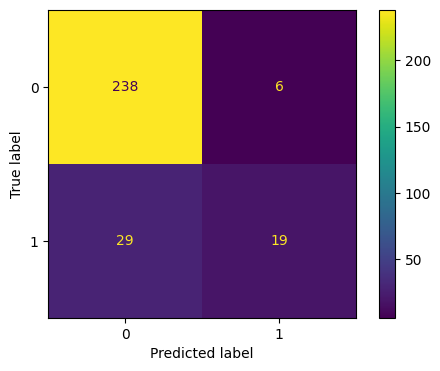

In [124]:
# Logistic Regression Model to Identify Expensive Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, y_test_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

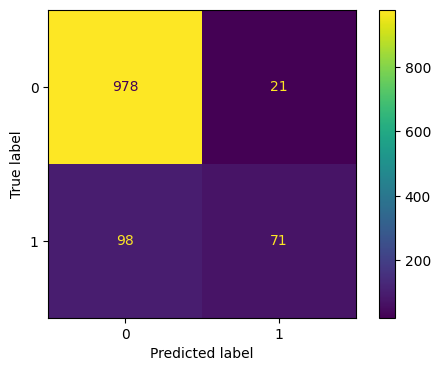

In [125]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, y_train_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

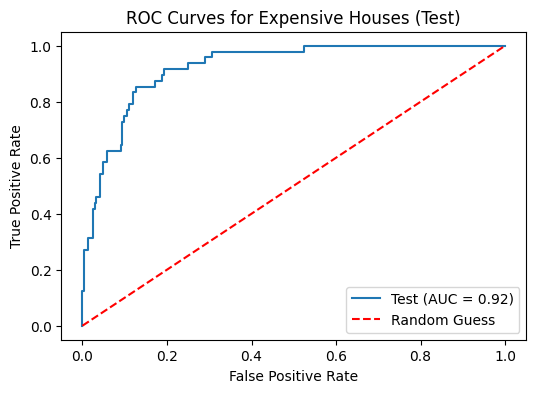

In [127]:
y_pred1 = clf_ex2.predict_proba(X_test_expensive)[:,1]
#y_pred2 = clf_ex.predict_proba(X_train_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_expensive, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Test)')
plt.legend()
plt.show()

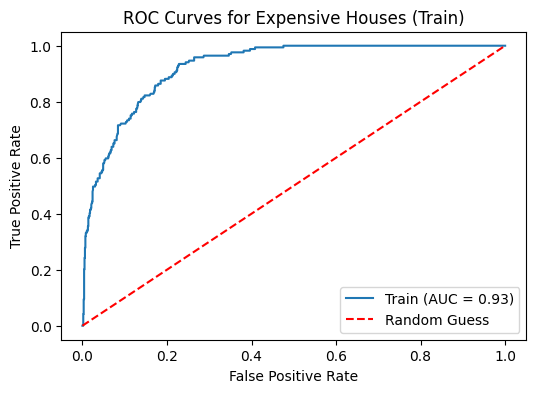

In [128]:
y_pred1 = clf_ex2.predict_proba(X_train_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_expensive, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Train)')
plt.legend()
plt.show()